In [9]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sub import estimate

importlib.reload(estimate)

plt.rcParams["figure.figsize"] = (20, 12)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [10]:
# LOG_FILE_PATH = "../trials/Track5_second_evaluation_01_pdr.txt"
LOG_FILE_PATH = "../trials/4_1_51.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [11]:
from sub import pdr

importlib.reload(pdr)

data = pdr.read_log_data(LOG_FILE_PATH)
acc_df, gyro_df, mgf_df, ground_truth_df, blescans_df = pdr.convert_to_dataframes(data)

In [12]:
from sub import pdr

importlib.reload(pdr)

map_dict = pdr.load_floor_maps(FLOOR_NAMES, "../gis/")
edit_map_dict = pdr.load_floor_maps(FLOOR_NAMES, "../gis/", "_edited")
floor_name = ground_truth_df.floor[0]

dx = 0.01
dy = 0.01

In [13]:
from scipy.signal import find_peaks

acc_df["norm"] = np.sqrt(acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2)
acc_df["rolling_norm"] = acc_df["norm"].rolling(10).mean()

peaks, _ = find_peaks(acc_df["rolling_norm"], height=12, distance=10)

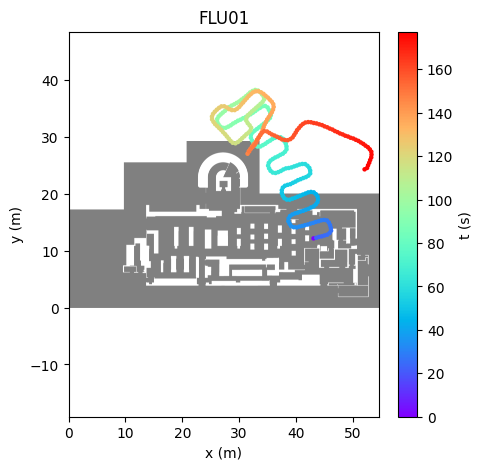

In [17]:
from sub import pdr, utils

importlib.reload(utils)
importlib.reload(pdr)

trajectory_df, cumulative_displacement_angle = (
    pdr.estimate_trajectory_with_ground_tooth_first_point(
        acc_df,
        gyro_df,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
    )
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    trajectory_df,
    display_map=True,
)

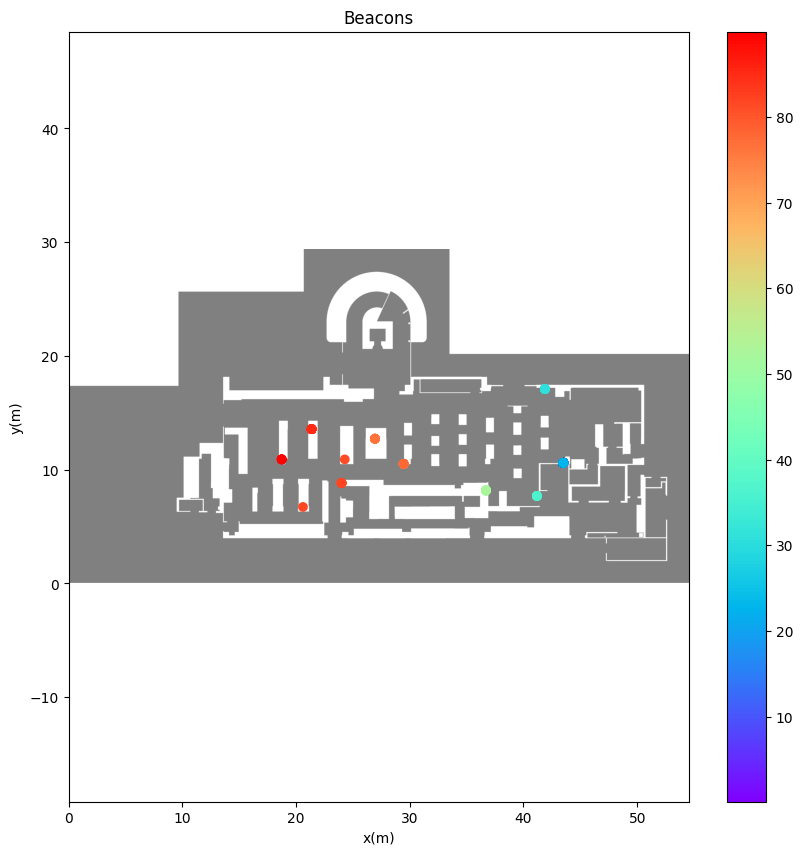

In [18]:
import numpy as np
import pandas as pd

# 軌跡前半の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索
# これは軌跡前半はドリフトが乗りづらいため
# 時間全体の中央を変数に入れる
center_of_time = blescans_df.tail(1)["ts"].values[0] / 2

first_half_strong_blescans = estimate.filter_strong_blescans(
    blescans_df,
    center_of_time,
    -76,
)
merged_strong_blescans_first_half = estimate.load_beacons_and_merge(
    BEACON_LIST_PATH,
    first_half_strong_blescans,
)


# マップ上にビーコンの位置をプロット
estimate.plot_map(map_dict, floor_name, dx, dy)

plt.colorbar(
    plt.scatter(
        merged_strong_blescans_first_half.x,
        merged_strong_blescans_first_half.y,
        c=merged_strong_blescans_first_half["ts"],
        cmap="rainbow",
    ),
)

plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("Beacons")
plt.show()

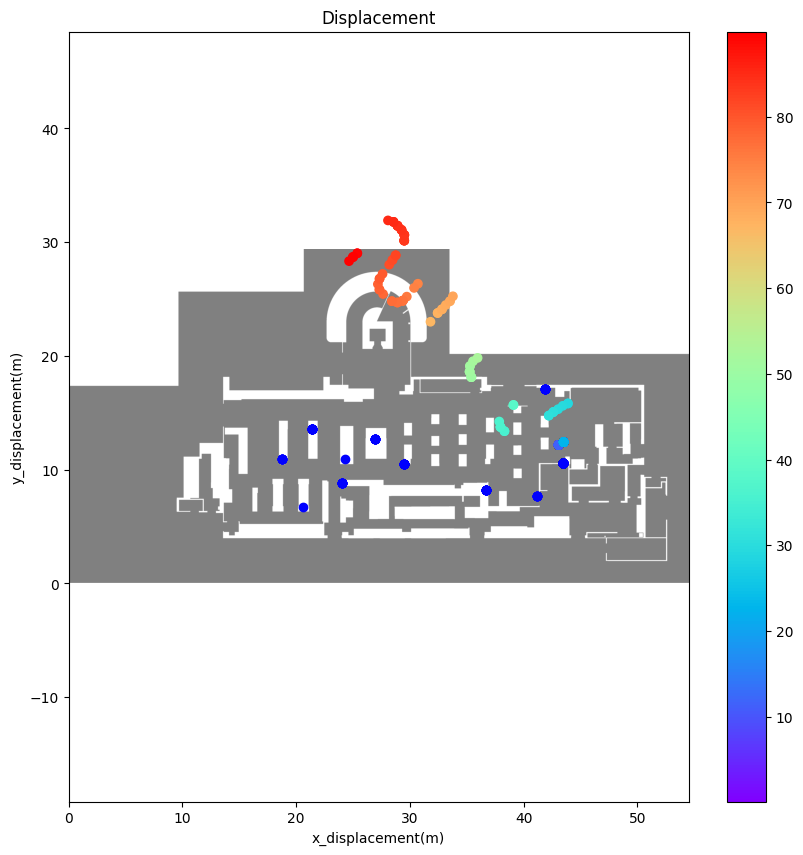

In [19]:
rotated_cumulative_displacement_df = estimate.rotate_cumulative_displacement(
    trajectory_df,
    0.3,
    {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
)


# 同じ bdaddress, x, y を持つデータをグループ化
merged_df = pd.merge_asof(
    merged_strong_blescans_first_half,
    rotated_cumulative_displacement_df,
    on="ts",
    direction="nearest",
)

# マップ上にx_displacement,y_displacementとビーコンの位置をプロット
estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        merged_df.x_displacement,
        merged_df.y_displacement,
        c=merged_df["ts"],
        cmap="rainbow",
    ),
)
plt.scatter(merged_df.x, merged_df.y, c="blue")

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

In [21]:
# 角度データフレームの生成
angle_df = estimate.convert_to_angle_from_gyro(gyro_df)
# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()
angle_in_step_timing = estimate.match_data(angle_df, acc_df.ts[peaks])

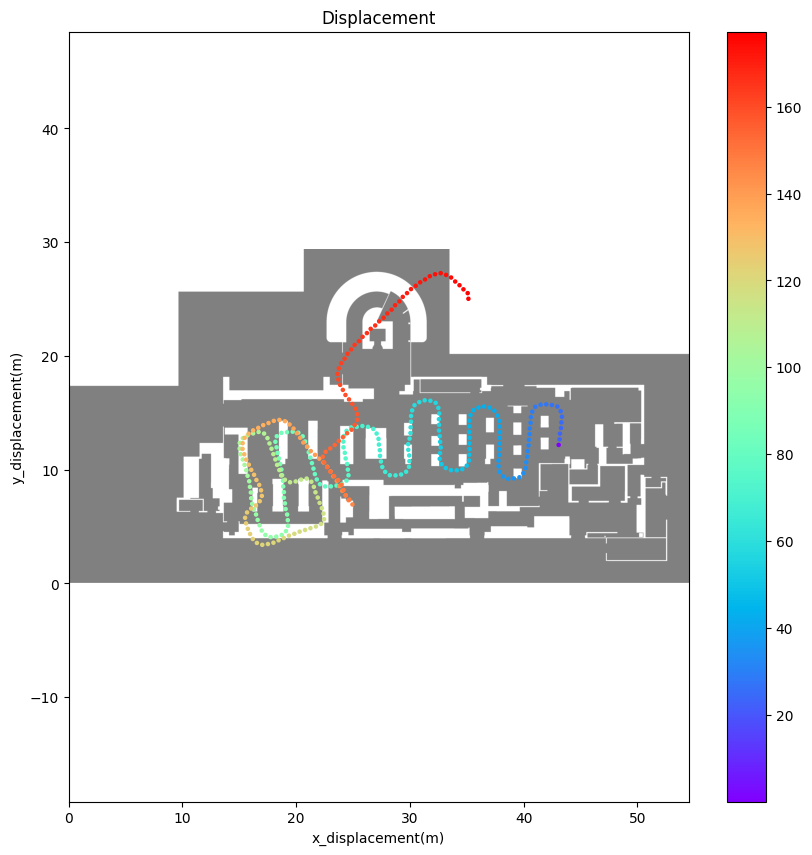

In [22]:
angle = estimate.search_optimal_angle(
    trajectory_df,
    ground_truth_df,
    merged_strong_blescans_first_half,
)

rotate_by_first_half_angle = pd.DataFrame(
    {
        "ts": angle_in_step_timing.ts,
        "x": angle_in_step_timing.x + angle,
    },
)

rotate_by_first_half_angle_displacement = estimate.calculate_cumulative_displacement(
    rotate_by_first_half_angle.ts,
    rotate_by_first_half_angle["x"],
    0.5,
    {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
    ground_truth_df["%time"][0],
)

estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        rotate_by_first_half_angle_displacement.x_displacement,
        rotate_by_first_half_angle_displacement.y_displacement,
        c=rotate_by_first_half_angle_displacement.ts,
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()